In [1]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.cosmology import Planck18
from scipy.special import erf, erfc,erfcx
import scipy
import emcee
import corner
from astropy.table import Table
from astropy.io import fits
import fitsio
import matplotlib as mpl
from multiprocessing import Pool

In [2]:
k = Table.read('/pscratch/sd/z/zhaozhon/DATASET/DESI-data/k.csv',format='csv')
indice = np.isnan(k['k_gg']) | np.isinf(k['k_gg']) | np.isnan(k['k_rr']) | np.isinf(k['k_rr'])
k_gg = k['k_gg'][~indice]
k_rr = k['k_rr'][~indice]

In [3]:
file = '/pscratch/sd/z/zhaozhon/DATASET/DESI-data/new_d.fits'
d = Table(fitsio.read(file))
SEL = np.where((d['Z'] > 2.1) & (d['Z'] < 2.8))[0]
apr_mag_g = d['APP_MAG_G'][SEL][~indice]
apr_mag_g_err = d['APP_MAGERR_G'][SEL][~indice]
apr_mag_r = d['APP_MAG_R'][SEL][~indice]
apr_mag_r_err = d['APP_MAGERR_R'][SEL][~indice]
z = d['Z'][SEL][~indice]

In [4]:
d = Planck18.distmod(z).value

In [5]:
def log_likelihood(params,apr_mag, magerr, d, k, m_lim):
    # Filter arrays based on the limiting magnitude
    sigma_I, M_X = params
    indice = apr_mag < m_lim
    filtered_apr_mag = apr_mag[indice]
    filtered_magerr = magerr[indice]
    filtered_d = d[indice]
    filtered_k = k[indice]
    # Calculate the variance for the filtered data
    variance = sigma_I**2 + filtered_magerr**2
    
    # Calculate each term of the log-likelihood
    term1 = -0.5 * np.log(2 * np.pi * variance)
    term2 = -0.5 * (filtered_apr_mag - (M_X + filtered_k + filtered_d))**2 / variance 
    term3 = -np.log( erfcx(-(m_lim - filtered_apr_mag) / np.sqrt(2 * variance))) + (((m_lim - filtered_apr_mag)) / np.sqrt(2 * variance))**2
    total_log_likelihood = np.sum(term1 +term2+term3)
    print(total_log_likelihood.shape)
    return total_log_likelihood

In [6]:
%%capture
# Define the log prior
def log_prior(params):
    sigma_I, M_X = params
    if 0 < sigma_I < 10 and -30 < M_X < -20:  # Example ranges, adjust as necessary
        return 0.0  # log(1) for uniform prior
    return -np.inf  # log(0) outside the prior ranges

# Define the log posterior
def log_posterior(params, apr_mag, magerr, d, k, m_lim):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, apr_mag, magerr, d, k, m_lim)

ndim = 2  # Number of parameters
nwalkers = 100  # Number of MCMC walkers
nsteps = 2000  # Number of MCMC steps
start_pos = [1, -25] + 0.1 * np.random.randn(nwalkers, ndim)

# Using multiprocessing pool
with Pool(processes=64) as pool:
    sampler_gg = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(apr_mag_g, apr_mag_g_err, d, k_gg, 22.5), pool=pool)
    sampler_gg.run_mcmc(start_pos, nsteps, progress=True)

# Get the samples, discarding the burn-in
samples_gg = sampler_gg.get_chain(discard=500, flat=True)

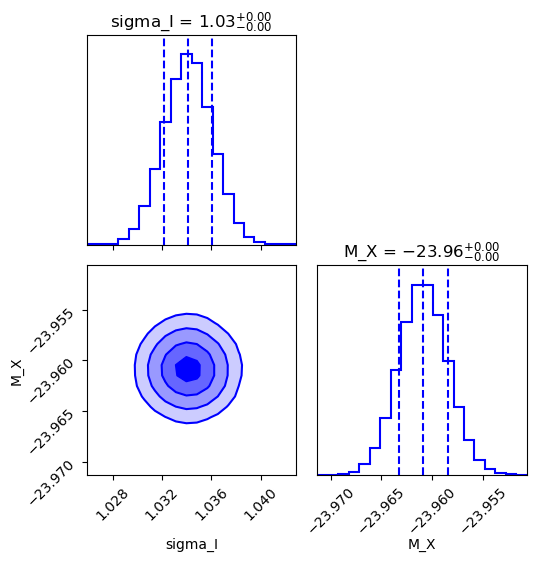

In [7]:
fig_gg = corner.corner(
    samples_gg,
    labels=["sigma_I", "M_X"],
    truths=[0.01, -25],
    quantiles=[0.16, 0.5, 0.84],  # Show the 16th, 50th, and 84th percentiles
    show_titles=True,
    title_kwargs={"fontsize": 12},
    plot_datapoints=False,
    plot_density=True,
    fill_contours=True,
    smooth=1.0,
    hist_kwargs={"linewidth": 1.5, "histtype": "step", "density": True},
    color='blue',
    truth_color='red'
)

#fig.suptitle('MCMC Parameter Estimation', fontsize=16)

# Increase subplot margins to provide more space for labels
fig_gg.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95, wspace=0.1, hspace=0.1)

# If overlapping persists, consider rotating labels or adjusting manually
for ax in fig_gg.get_axes():
    ax.tick_params(axis='x', labelrotation=45)  # Rotate x-axis labels for better fit
    ax.tick_params(axis='y', labelrotation=45)  # Rotate y-axis labels for better fit
plt.savefig('/global/u1/z/zhaozhon/Plots/MCMC-1-gg', dpi=300)
plt.show()  # Show the plot

In [8]:
try:
    tau = sampler_gg.get_autocorr_time()
    print(f"Autocorrelation time for g band: {tau}")
except RuntimeError as e:
    print(f"Autocorrelation calculation failed for g band: {e}")

Autocorrelation time for g band: [23.19344541 27.59017618]


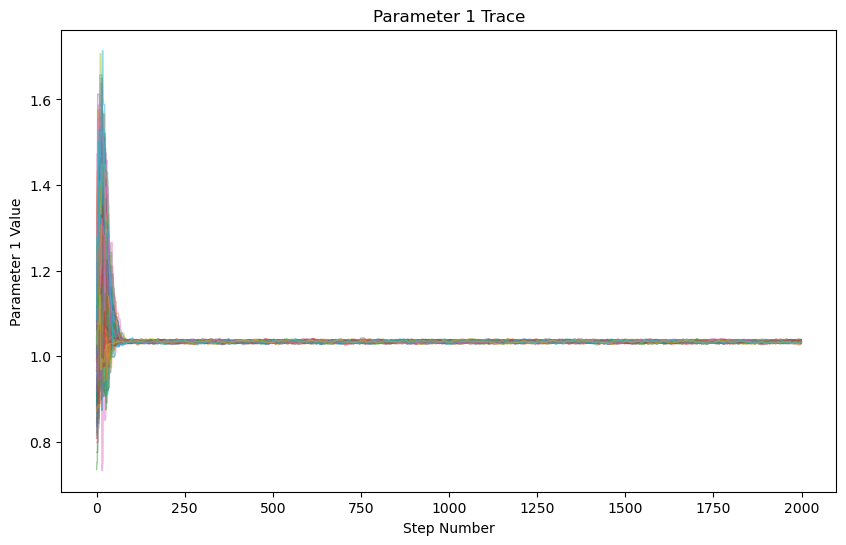

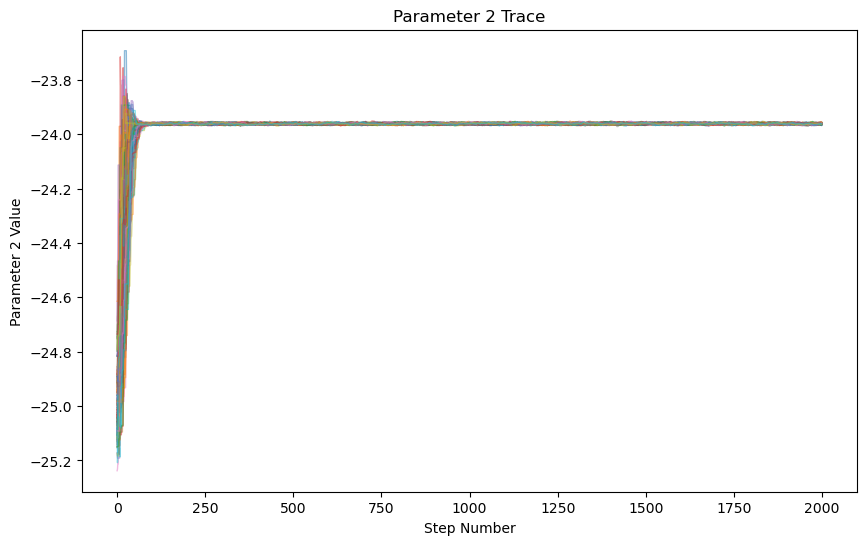

In [9]:
nsteps = sampler_gg.chain.shape[1]
for i in range(sampler_gg.chain.shape[2]):  # For each parameter
    plt.figure(figsize=(10, 6))
    for chain in sampler_gg.chain[..., i]:
        plt.plot(chain, alpha=0.5, lw=1)
    plt.title(f"Parameter {i+1} Trace")
    plt.xlabel("Step Number")
    plt.ylabel(f"Parameter {i+1} Value")
    plt.savefig(f"/global/u1/z/zhaozhon/Plots/MCMC-parameter{i+1} for g band", dpi=300)
    plt.show()